# 고혈압 분석 모델
## @author: sh22h

- year0_NA를 DataFrame으로 불러오고 4개로 나눔
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  - categoryH0: 계층 없는 범주형(>3) 변수, one-hot-encoding
  - categoryH1: 계층 있는 범주형 변수, 표준화
  - ctn:연속형 변수, 정규화, 표준화 
  - hyperTension: 고혈압

- 각각 정규화 또는 표준화한 후 변수는 X 고혈압은 y로 둠
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수

## 학습 모델

- 0차
  - 로컬에서 구현

- 1차
  - 2021-07-20
  - normalize_ctn
  - 
  ```
  model = Sequential()
  model.add(Dense(12, input_dim=52, activation='relu'))  # input layer requires input_dim param
  model.add(Dense(15, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
  scores = model.evaluate(X_test, y_test)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
  ```

- 2차
  - 2021-07-26
  - Decision Tree 구현

- 3차
  - 2021-08-02
  - one-hot encoding 구현

- 4차
  - 2021-08-07
  - 전처리 개선
  - Keras Tunor 사용 준비
  - P1 ~ P4 모델 구현

- 5차
  - 2021-08-08
  - 데이터 결측값 관리
    - TOTALC 유의미한 값: 15개
    - 키, 몸무게 결측값 매우 많음
  - 데이터 결측값 제거
    - TOTALC 삭제
    - KNNImputer로 결측값 채우기
    - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

- 6차
  - 2021-08-12
  - 데이터 결측값 관리
    - 변수 모두 포함하라!
    - 범주형: 최빈값
    - 수치형: 평균값(kNN)
    - TOTALC 포함하라
    - 주말까지
  - DicisionTree 보는 법을 해석하라.
  - 모델 정확도 올리기

- 7차
  - 2021-08-23
  - unit 통일
  - dropout 통일
  - 모델 정확도 여전히 안좋음

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 데이터 불러오기

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/year0_NA.csv', index_col=0, na_values=['NA'])

idx_dataset = list(dataset.index)
col_dataset = list(dataset.columns)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 53 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AS1_SEX        9704 non-null   int64  
 1   AS1_AGE        9704 non-null   int64  
 2   AS1_JOBB       9698 non-null   float64
 3   AS1_EDUA       9650 non-null   float64
 4   AS1_INCOME     9566 non-null   float64
 5   AS1_DRINK      9664 non-null   float64
 6   AS1_DRDUA      9545 non-null   float64
 7   AS1_TOTALC     5116 non-null   float64
 8   AS1_SMOKEA     9616 non-null   float64
 9   AS1_HVSMAM     9542 non-null   float64
 10  AS1_HVSMDU     9522 non-null   float64
 11  AS1_PHYSTB     9601 non-null   float64
 12  AS1_PHYSIT     9582 non-null   float64
 13  AS1_PHYACTL    9568 non-null   float64
 14  AS1_PHYACTM    9502 non-null   float64
 15  AS1_PHYACTH    9541 non-null   float64
 16  AS1_INSUR      9682 non-null   float64
 17  AS1_HEALTH     9675 non-nu

### dataset 결측값 대치, 정규화

In [ ]:
# dataset에 있는 변수 분리
# 범주형, 연속형 등으로 분리하여 raw_var 형태로 저장하여 각각 관리한다.

# 종속변수, 고혈압
HYPERTENSION = dataset['HYPERTENSION']

# 범주형(binary, 0 or 1)
raw_binary = dataset.reindex(columns=['AS1_SEX', 'AS0_TIED', 'AS0_SLPAMSF', 'AS1_STRPHYSJ'])
col_b = raw_binary.columns

#범주형(계층 없음, without hierarchy)
raw_categoryH0 = dataset.reindex(columns=['AS1_JOBB', 'AS1_INSUR'])
col_H0 = raw_categoryH0.columns

# 범주형(계층 있음, with hierarchy)
raw_categoryH1 = dataset.reindex(columns=['AS1_EDUA', 'AS1_INCOME', 'AS1_DRINK', 'AS1_DRDUA',
                                 'AS1_SMOKEA', 'AS1_PHYSTB', 'AS1_PHYSIT', 'AS1_PHYACTL',
                                 'AS1_PHYACTM', 'AS1_PHYACTH', 'AS1_HEALTH'
                                 ])
col_H1 = raw_categoryH1.columns

# 연속형 변수
raw_ctn = dataset.reindex(columns=['AS1_AGE', 'AS1_HVSMAM', 'AS1_HVSMDU', 'AS1_TOTALC',
                          'AS1_SLPAMTM', 'AS1_RGMEALFQA', 'AS1_HEIGHT', 'AS1_WEIGHT',
                          'AS1_B01', 'AS1_B02', 'AS1_B03', 'AS1_B04', 'AS1_B05',
                          'AS1_B06', 'AS1_B07', 'AS1_B08', 'AS1_B09', 'AS1_B10',
                          'AS1_B11', 'AS1_B12', 'AS1_B13', 'AS1_B14', 'AS1_B15',
                          'AS1_B16', 'AS1_B17', 'AS1_B18', 'AS1_B19', 'AS1_B20',
                          'AS1_B21', 'AS1_B23', 'AS1_B24', 'P1', 'P2', 'P3', 'P4'
                          ])
col_c = raw_ctn.columns

In [ ]:
print(raw_binary.info(), raw_categoryH0.info(), raw_categoryH1.info(), raw_ctn.info())
print(col_b, col_H0, col_H1, col_c)

<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AS1_SEX       9704 non-null   int64  
 1   AS0_TIED      9603 non-null   float64
 2   AS0_SLPAMSF   9654 non-null   float64
 3   AS1_STRPHYSJ  9704 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 379.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AS1_JOBB   9698 non-null   float64
 1   AS1_INSUR  9682 non-null   float64
dtypes: float64(2)
memory usage: 227.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   

In [ ]:
from sklearn.impute import KNNImputer, SimpleImputer

In [ ]:
imp_kNN = KNNImputer(n_neighbors=5)
imp_mean = SimpleImputer(strategy='mean')
imp_mostFreq = SimpleImputer(strategy='most_frequent')

binary = pd.DataFrame(imp_mostFreq.fit_transform(raw_binary),
                      index=idx_dataset, columns=col_b).astype('float') # float형으로 변경.

categoryH0 = pd.DataFrame(imp_mostFreq.fit_transform(raw_categoryH0), 
                          index=idx_dataset, columns=col_H0)
categoryH0 = pd.get_dummies(categoryH0, columns=col_H0).astype('float') # one-hot-encoding

categoryH1 = pd.DataFrame(imp_mostFreq.fit_transform(raw_categoryH1),
                          index=idx_dataset, columns=col_H1)

# 둘 중 하나만 사용할 예정
ctn = pd.DataFrame(imp_kNN.fit_transform(raw_ctn), index=idx_dataset, columns=col_c)
# ctn = pd.DataFrame(imp_mean.fit_transform(raw_ctn), index=idx_dataset, columns=col_c)


In [ ]:
print(binary.info(), categoryH0.info(), categoryH1.info(), ctn.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AS1_SEX       9704 non-null   float64
 1   AS0_TIED      9704 non-null   float64
 2   AS0_SLPAMSF   9704 non-null   float64
 3   AS1_STRPHYSJ  9704 non-null   float64
dtypes: float64(4)
memory usage: 379.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AS1_JOBB_0.0   9704 non-null   float64
 1   AS1_JOBB_1.0   9704 non-null   float64
 2   AS1_JOBB_2.0   9704 non-null   float64
 3   AS1_JOBB_3.0   9704 non-null   float64
 4   AS1_JOBB_4.0   9704 non-null   float64
 5   AS1_JOBB_5.0   9704 non-null   float64
 6   AS1_JOBB_6.0   9704 non-null   float64
 7   AS1_JOBB_7.0   9704 non-null   fl

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split

In [ ]:
# category_h1, ctn 정규화
# train만으로 scale 해야하는가? 교수님에게 질문해보기

scaler0 = StandardScaler()
scaler1 = MinMaxScaler()
scaler2 = QuantileTransformer()

def standard(categoryH1, ctn):
  categoryH1[col_H1] = scaler0.fit_transform(categoryH1)
  ctn[col_c] = scaler0.fit_transform(ctn)

  return categoryH1, ctn


def minmax(categoryH1, ctn):
  categoryH1[col_H1] = scaler1.fit_transform(categoryH1)
  ctn[col_c] = scaler1.fit_transform(ctn)

  return categoryH1, ctn


def quantile(categoryH1, ctn):
  categoryH1[col_H1] = scaler2.fit_transform(categoryH1)
  ctn[col_c] = scaler2.fit_transform(ctn)

  return categoryH1, ctn


In [ ]:
categoryH1, ctn = standard(categoryH1, ctn)
# categoryH1, ctn = minmax(categoryH1, ctn)
# categoryH1, ctn = quantile(categoryH1, ctn)

In [ ]:
ctn.describe()

,AS1_AGE,AS1_HVSMAM,AS1_HVSMDU,AS1_TOTALC,AS1_SLPAMTM,AS1_RGMEALFQA,AS1_HEIGHT,AS1_WEIGHT,AS1_B01,AS1_B02,AS1_B03,AS1_B04,AS1_B05,AS1_B06,AS1_B07,AS1_B08,AS1_B09,AS1_B10,AS1_B11,AS1_B12,AS1_B13,AS1_B14,AS1_B15,AS1_B16,AS1_B17,AS1_B18,AS1_B19,AS1_B20,AS1_B21,AS1_B23,AS1_B24,P1,P2,P3,P4
count,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03,9.704000e+03
mean,2.596622e-16,-6.963034e-16,-1.579974e-15,-2.372118e-15,-8.702963e-16,-1.034805e-15,-3.906946e-15,1.562824e-17,-5.011106e-17,3.177132e-17,-1.254493e-16,1.190652e-16,-4.141599e-17,1.019382e-16,8.324385e-16,8.008616e-19,-3.889899e-19,-1.151410e-16,-3.763134e-16,1.188078e-16,8.203111e-18,-7.200890e-17,-1.021442e-16,6.438927e-16,9.093212e-17,-7.299282e-18,4.505419e-17,4.056479e-16,2.193674e-16,6.035064e-17,-2.951747e-18,1.873845e-16,9.236223e-17,-3.055287e-17,5.519653e-17
std,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00,1.000052e+00
min,-1.371295e+00,-4.984460e-01,-5.303083e-01,-6.443553e-02,-4.165798e+00,-5.253905e+00,-4.459664e+00,-3.469996e+00,-2.562836e+00,-1.963643e+00,-1.469164e+00,-2.726789e+00,-1.688405e+00,-2.186936e+00,-1.858641e+00,-1.926757e+00,-1.301728e+00,-1.858211e+00,-1.988408e+00,-1.890463e+00,-1.903432e+00,-1.282149e+00,-1.697243e+00,-2.035758e+00,-1.724563e+00,-1.058913e+00,-1.141055e+00,-1.310796e+00,-1.712505e+00,-1.487501e+00,-1.223910e+00,-4.541076e-01,-5.658906e-01,-2.654945e+00,-7.962131e-01
25%,-9.224567e-01,-4.984460e-01,-5.303083e-01,-6.443553e-02,-5.455838e-01,3.530954e-01,-6.338171e-01,-6.217923e-01,-6.092224e-01,-6.128791e-01,-6.312781e-01,-5.555852e-01,-6.814846e-01,-6.508712e-01,-7.398939e-01,-6.620698e-01,-6.111536e-01,-6.707185e-01,-4.241185e-01,-7.069781e-02,-6.520912e-01,-6.041761e-01,-6.103408e-01,-9.039907e-01,-6.464307e-01,-6.725679e-01,-5.776575e-01,-6.487704e-01,-5.852969e-01,-6.086754e-01,-6.677902e-01,-4.061179e-01,-4.103148e-01,-4.306874e-01,-7.191960e-01
50%,-2.491992e-01,-4.984460e-01,-5.303083e-01,-6.443553e-02,1.784589e-01,3.530954e-01,-1.172827e-02,-2.841649e-02,-1.666834e-01,-1.516428e-01,-2.123352e-01,-1.714492e-01,-1.945013e-01,-1.514145e-01,-1.805205e-01,-1.709627e-01,-2.526325e-01,-1.622216e-01,-4.241185e-01,-7.069781e-02,-2.349775e-01,-2.651894e-01,-1.755799e-01,2.277763e-01,-2.046959e-01,-2.089542e-01,-2.733241e-01,-3.177574e-01,-3.034948e-01,-2.571452e-01,-2.298462e-01,-3.468364e-01,-2.301743e-01,-1.431982e-01,-2.827658e-01
75%,8.728967e-01,-2.745021e-01,-1.404974e-01,-6.443553e-02,9.025017e-01,3.530954e-01,6.725695e-01,5.649593e-01,3.836895e-01,3.754845e-01,3.928046e-01,3.462993e-01,4.499276e-01,4.452242e-01,3.788529e-01,4.164841e-01,2.839461e-01,4.512436e-01,-4.241185e-01,-7.069781e-02,4.602120e-01,2.732013e-01,2.591809e-01,2.277763e-01,3.792925e-01,3.628360e-01,2.174365e-01,2.780659e-01,5.419115e-01,4.459152e-01,4.027395e-01,-8.712728e-02,7.278929e-02,3.107320e-01,3.693122e-01
max,1.882783e+00,8.459310e+00,4.225385e+00,3.540800e+01,5.970801e+00,5.960096e+00,3.783014e+00,4.955940e+00,1.124270e+01,1.618930e+01,1.552130e+01,1.060941e+01,1.005778e+01,1.295461e+01,1.249861e+01,1.085716e+01,1.407859e+01,8.134779e+00,1.365449e+01,1.266766e+01,2.145494e+01,1.244681e+01,2.243198e+01,1.154545e+01,1.187937e+01,1.779471e+01,1.534768e+01,7.295541e+00,1.0968

### dataset 분리
- train, test

In [ ]:
X = pd.concat([binary, categoryH0, categoryH1, ctn], axis=1)
y = dataset['HYPERTENSION']  # 고혈압 변수

# 훈련 데이터 나눔
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6792, 62) (2912, 62) (6792,) (2912,)


### 모델 제작

In [ ]:
import IPython
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

!pip install -U keras-tuner
import kerastuner as kt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
from kerastuner import HyperModel

class RegressionHyperModel(HyperModel):
  def __init__(self, input_shape):
    self.input_shape = input_shape

def model_builder(hp):
  model = Sequential()

  hp_units0 = hp.Int('units_0', min_value = 4, max_value = 32, step = 2)
  hp_units1 = hp.Int('units_1', min_value = 4, max_value = 32, step = 2)
  hp_units2 = hp.Int('units_2', min_value = 4, max_value = 32, step = 2)
  hp_units3 = hp.Int('units_3', min_value = 4, max_value = 32, step = 2)
  hp_units4 = hp.Int('units_4', min_value = 4, max_value = 32, step = 2)

  hp_dropout0 = hp.Float('dropout_0', min_value=0.0, max_value=0.1, default=0.005, step=0.005)
  hp_dropout1 = hp.Float('dropout_1', min_value=0.0, max_value=0.1, default=0.005, step=0.005)

  model.add(Dense(units = hp_units0,
                  activation='relu',
                  input_shape=input_shape)) # input_shape = 62
        
  model.add(Dense(units = hp_units1,
                  activation='relu'))
  
  model.add(Dropout(hp_dropout0))
  
  model.add(Dense(units = hp_units2,
                  activation='relu'))
  
  model.add(Dense(units = hp_units3,
                  activation='relu'))
  
  model.add(Dense(units = hp_units4,
                  activation='relu'))
        
  model.add(Dropout(hp_dropout1))
        
  model.add(Dense(1, activation='sigmoid')) # 출력층

  # Tune the learning rate for the optimizer S
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-3]) #0.001

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss="binary_crossentropy", # 손실함수: binary_crossentropy
                metrics = ['accuracy']) # 평가지표

  # model.compile(optimizer='rmsprop', 
  #               loss='mse', metrics=['mse']) #손실함수: MSE(mean squared error)
  
  return model

In [ ]:
input_shape = (X_train.shape[1],)
hypermodel = RegressionHyperModel(input_shape)

tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 50,
                     factor = 7,
                     hyperband_iterations = 300,
                     directory = '/content/drive/MyDrive/Colab Notebooks',
                     project_name = 'HyperTension_sh22h7') 

In [ ]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(X_train, y_train, epochs = 100, validation_data = (X_test, y_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
{best_hps.get('units_0'), best_hps.get('units_1'), best_hps.get('units_2'), best_hps.get('units_3'), best_hps.get('units_4')}
and the optimal learning rate for the optimizer is
{best_hps.get('learning_rate')}
drop-out is
{best_hps.get('dropout_0'), best_hps.get('dropout_1')}.
""")

213/213 [==============================] - 1s 3ms/step - loss: 0.3660 - accuracy: 0.8413 - val_loss: 0.6181 - val_accuracy: 0.7534
Epoch 35/50
213/213 [==============================] - 1s 3ms/step - loss: 0.3606 - accuracy: 0.8435 - val_loss: 0.6433 - val_accuracy: 0.7291
Epoch 36/50
213/213 [==============================] - 1s 3ms/step - loss: 0.3548 - accuracy: 0.8507 - val_loss: 0.6764 - val_accuracy: 0.7260
Epoch 37/50
213/213 [==============================] - 1s 3ms/step - loss: 0.3471 - accuracy: 0.8504 - val_loss: 0.6549 - val_accuracy: 0.7328
Epoch 38/50
213/213 [==============================] - 1s 3ms/step - loss: 0.3445 - accuracy: 0.8544 - val_loss: 0.6702 - val_accuracy: 0.7270
Epoch 39/50
213/213 [==============================] - 1s 3ms/step - loss: 0.3468 - accuracy: 0.8523 - val_loss: 0.6548 - val_accuracy: 0.7321
Epoch 40/50
213/213 [==============================] - 1s 2ms/step - loss: 0.3396 - accuracy: 0.8564 - val_loss: 0.6651 - val_accuracy: 0.7291
Epoch 41/50

KeyboardInterrupt: ignored

#### best_hps

- 2021-08-08
  ```
  INFO:tensorflow:Oracle triggered exit
  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  72, 8, 104, 32)
   the optimal learning rate for the optimizer is
  0.001
  drop-out is
  (0.03, 0.06).
  ```
  - min_value = 8, max_value = 128, step = 8

- 2021-08-12
  ```
  Best val_accuracy So Far: 0.7678571343421936
  Total elapsed time: 00h 00m 33s
  INFO:tensorflow:Oracle triggered exit
  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  (10, 16, 6, 24)
  and the optimal learning rate for the optimizer is
  0.0001
  drop-out is
  (0.044, 0.096).
  ```

  - min_value = 2, max_value = 32, step = 2

- 2021-08-14
  ```
  Best val_accuracy So Far: 0.7726648449897766
  Total elapsed time: 00h 01m 27s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  (16, 8, 14, 8)
  and the optimal learning rate for the optimizer is
  0.0001
  drop-out is
  (0.085, 0.09).
  ```

  - min_value = 4, max_value = 32, step = 2

- 2021-08-23
  ```
  Trial 16 Complete [00h 00m 21s]
  val_accuracy: 0.7726648449897766

  Best val_accuracy So Far: 0.7743818759918213
  Total elapsed time: 00h 01m 49s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  28
  and the optimal learning rate for the optimizer is
  0.01
  drop-out is
  0.05.
  ```


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test), verbose=0)
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

In [ ]:
print(history.history)

In [ ]:
fig, ax0 = plt.subplots()
fig, ax1 = plt.subplots()

# 모델의 정확도를 그립니다.
ax0.plot(history.history['accuracy']) 
ax0.set(title='model accuracy', xlabel='epoch', ylabel='accuracy')

# 모델의 오차를 그립니다.
ax1.plot(history.history['loss'])
ax1.set(title='model loss', xlabel='epoch', ylabel='loss')

## Decision Tree

### 하이퍼 파라미터

- min_samples_split
  - 노드를 분할하기 위한 최소한의 샘플 데이터 수로 과적합 제어에 사용.
  - default는 2이다. 작게 설정할수록 분할되는 노드가 많아져 과적합 가능성 증가.
- min_samples_leaf
  - 말단 노드가 되기위한 최소한의 샘플 수
  - 과적합 제어 용도. 비대칭적 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있어 이 경우에는 작게 설정.
- max_features
  - 최적의 분할을 위해 고려할 최대 feature 개수. default는 None으로 데이터 세트의 모든 feature을 사용하여 분할.
  - int로 지정 시 대상 feature 개수, float로 지정 시 전체 feature중 대상 feature의 퍼센트
  - sqrt는 전체 feature중 제곱근 값.
  - auto는 sqrt와 동일
  - log는 전체 featur을 log2()로 선정
- max_depth
  - 트리의 최대 깊이 지정
  - default는 None. 이는 완벽히 클래스 결정값이 될때 까지 깊이를 계속 키우거나 노드가 가지는 데이터 개수가 min_samples_split보다 작아질 때 까지 계속 분할
  - 깊이가 깊어지면 min_samples_split 설정대로 최대 분할하여 과적합할 수 있으므로 적당한 값으로 제어.
- max_leaf_nodes
  - 말단 노드 최대 개수

- 출처: https://velog.io/@lsmmay322/%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%ACDecision-Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

ht_tree = DecisionTreeClassifier(max_depth=4,
                                 min_samples_leaf=6,
                                 random_state=123)
ht_tree.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [ ]:
export_graphviz(ht_tree, out_file="tree.dot",
                class_names='FT',
                feature_names=X.columns,
                impurity=True, filled=True)

In [ ]:
!ls

drive  sample_data  tree.dot


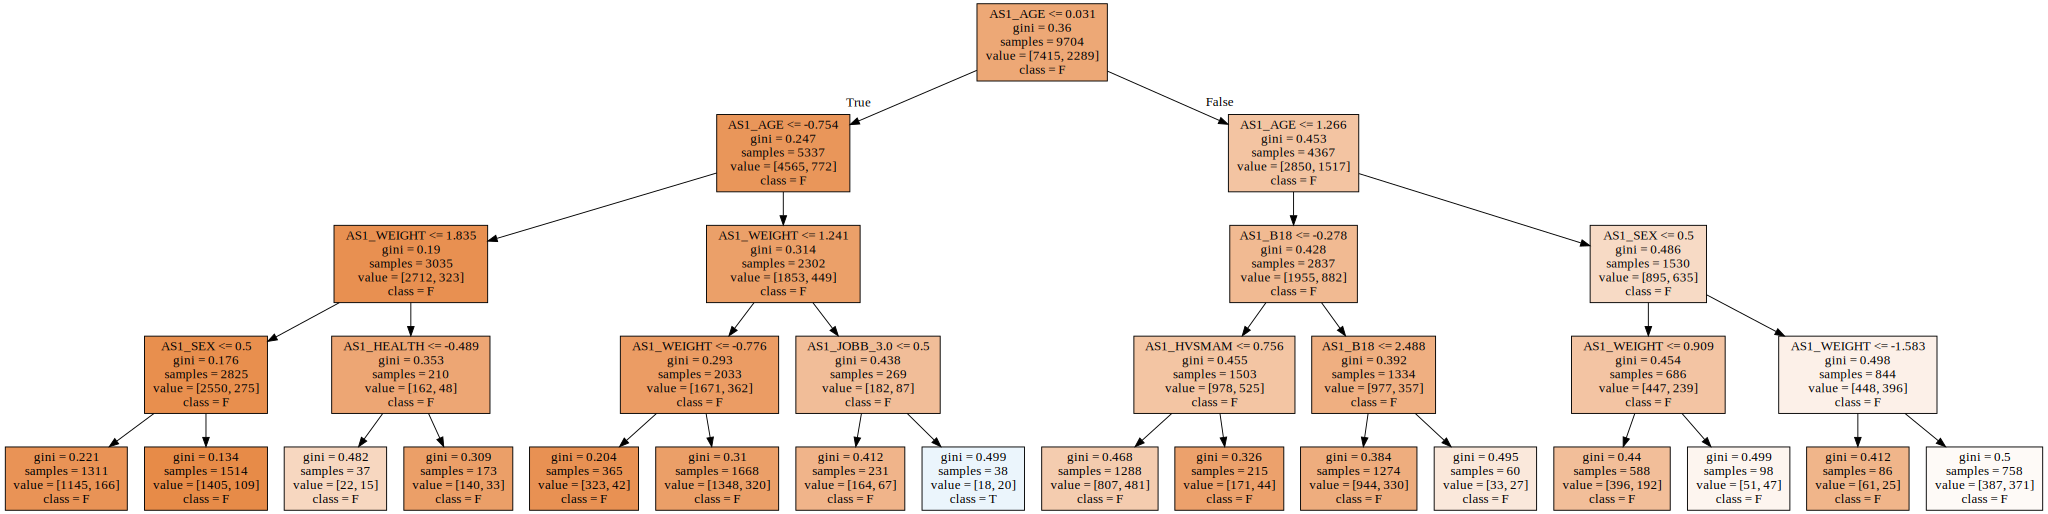

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph, filename='tree.png',format='png')

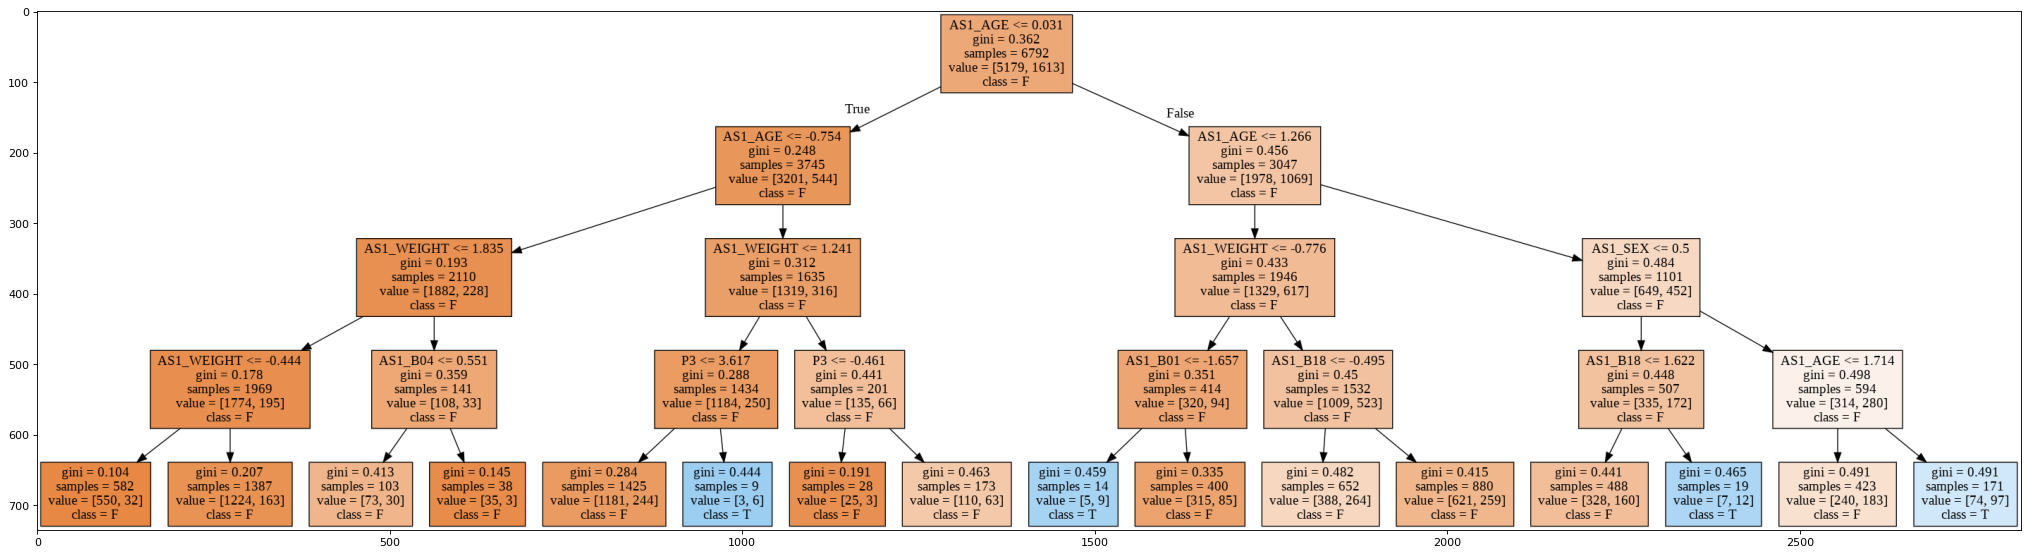

In [ ]:
!dot -Tpng tree.dot -o tree.png

tree_img = plt.imread('./tree.png')

plt.figure(num=None, figsize=(32, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(tree_img)

In [ ]:
print("훈련 세트 정확도: {:.3f}".format(ht_tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(ht_tree.score(X_test, y_test)))

importances = ht_tree.feature_importances_
print("특성 중요도:\n{}".format(importances))

훈련 세트 정확도: 0.768
테스트 세트 정확도: 0.763
특성 중요도:
[0.04078983 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.73494911 0.         0.
 0.         0.         0.         0.         0.10629195 0.02139872
 0.         0.         0.01068819 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.05353278 0.
 0.         0.         0.         0.         0.         0.
 0.03234942 0.        ]


Text(0, 0.5, 'feature importance')

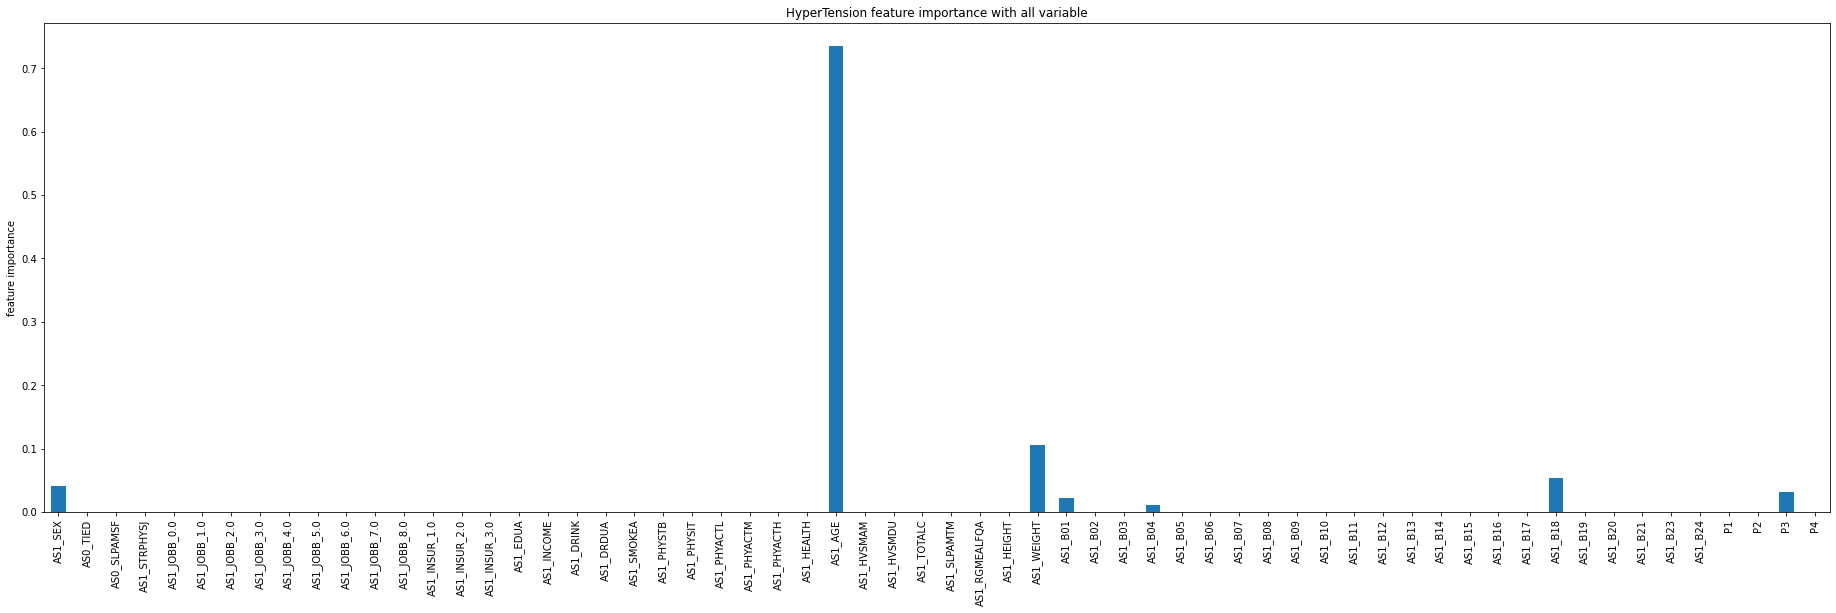

In [ ]:
# 특성 중요도 그래프

tree_importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots(figsize=(32, 9))
tree_importances.plot.bar(ax=ax)
ax.set_title("HyperTension feature importance with all variable")
ax.set_ylabel("feature importance")

### 특성 중요도가 낮은 것 제외하고 모델 제작해보기

- Decision tree로 변수의 특성 중요도 추출,

In [ ]:
X_cut = X[['AS1_SEX', 'AS1_AGE', 'AS1_WEIGHT',
          #  'AS1_B01', 'AS1_B04',
           'AS1_B18',
           'P1', 'P2', 'P3', 'P4']]
X_cut.head()

,AS1_SEX,AS1_AGE,AS1_WEIGHT,AS1_B18,P1,P2,P3,P4
EPI20_026_2_000001,1.0,1.882783,-0.004681,0.115575,-0.270617,-0.017281,0.265339,0.230681
EPI20_026_2_000002,0.0,1.546154,-0.360707,-0.610753,-0.296024,0.048225,-0.430687,-0.580565
EPI20_026_2_000003,0.0,1.209525,0.327609,-0.858013,-0.420233,-0.287492,-0.046360,-0.698658
EPI20_026_2_000004,1.0,0.424058,0.564959,0.501920,1.527586,0.048225,-0.430687,-0.375186
EPI20_026_2_000005,0.0,-1.146876,0.137729,-0.703475,0.872667,-0.484009,0.583090,-0.724330


In [ ]:
X_cut_train, X_cut_test, y_train, y_test = train_test_split(X_cut, y, test_size=0.3, random_state=123)
print(X_cut_train.shape, X_cut_test.shape, y_train.shape, y_test.shape)

(6792, 8) (2912, 8) (6792,) (2912,)


In [ ]:
cut_tree = DecisionTreeClassifier(max_depth=4)
cut_tree.fit(X_cut_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
export_graphviz(cut_tree, out_file="cut_tree.dot",
                class_names='FT',
                feature_names=X_cut.columns,
                impurity=True, filled=True)

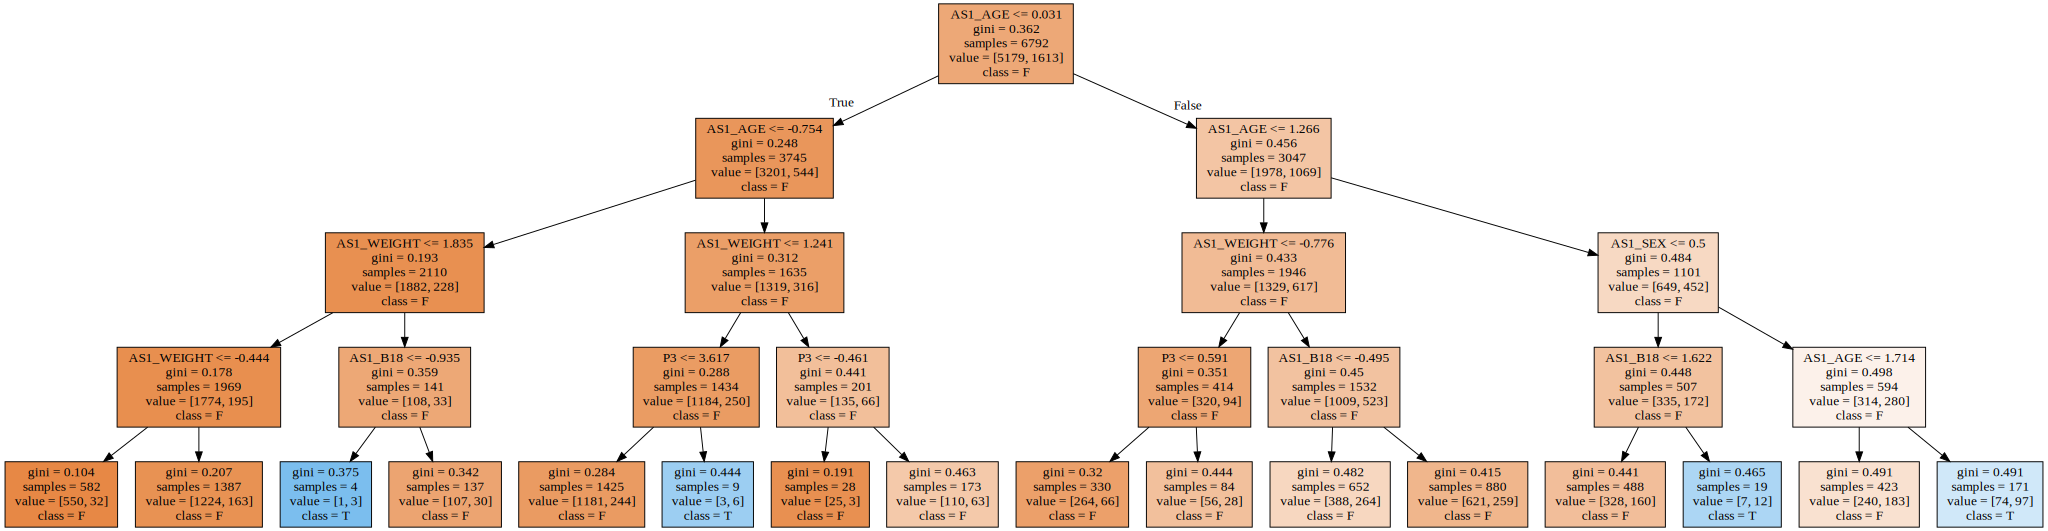

In [ ]:
with open("cut_tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph, filename='tree.png',format='png')

In [ ]:
print("훈련 세트 정확도: {:.3f}".format(cut_tree.score(X_cut_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(cut_tree.score(X_cut_test, y_test)))

importances = cut_tree.feature_importances_
print("특성 중요도:\n{}".format(importances))

훈련 세트 정확도: 0.767
테스트 세트 정확도: 0.763
특성 중요도:
[0.0413086  0.74429622 0.10764377 0.0636938  0.         0.
 0.04305761 0.        ]


Text(0, 0.5, 'feature importance')

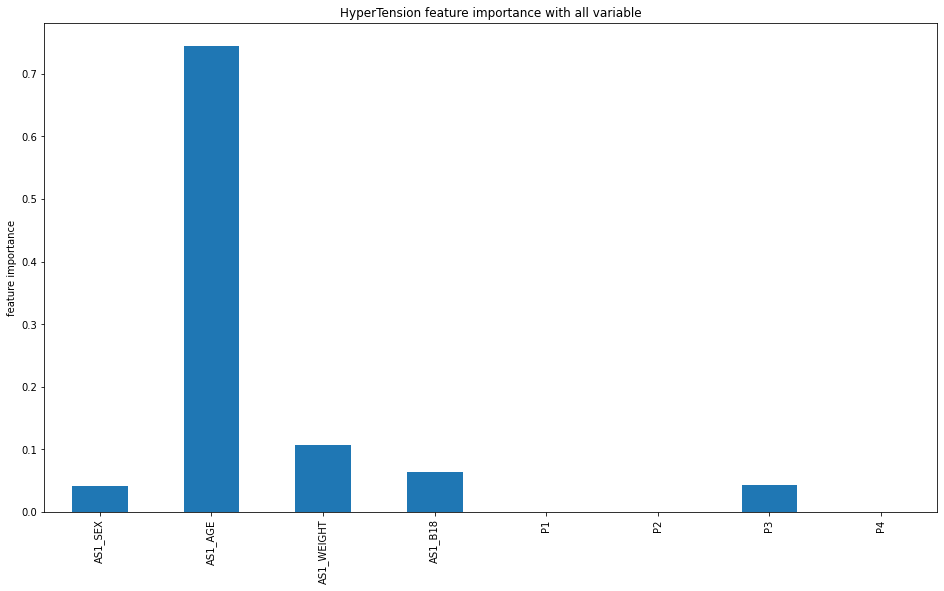

In [ ]:
# 특성 중요도 그래프

tree_importances = pd.Series(importances, index=X_cut.columns)
fig, ax = plt.subplots(figsize=(16, 9))
tree_importances.plot.bar(ax=ax)
ax.set_title("HyperTension feature importance with all variable")
ax.set_ylabel("feature importance")